# U net on roof labels

In [1]:
!pip install mycolorpy --quiet

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize

import keras.backend as K
import tensorflow as tf

from unet_detection.models.vanilla_unet import vanilla_unet

## Load data

In [4]:
X_train = np.load("data/spec_lib/X_data.npy") 
#X_70_train = np.load("data/spec_lib/X_70_data.npy")
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
#X_70_val = np.load("data/spec_lib/X_70_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
#X_70_test = np.load("data/spec_lib/X_70_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [5]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [6]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(150, 128, 128, 11)
(20, 128, 128, 11)
(50, 128, 128, 11)


## Show 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[127  35 112  30  23]


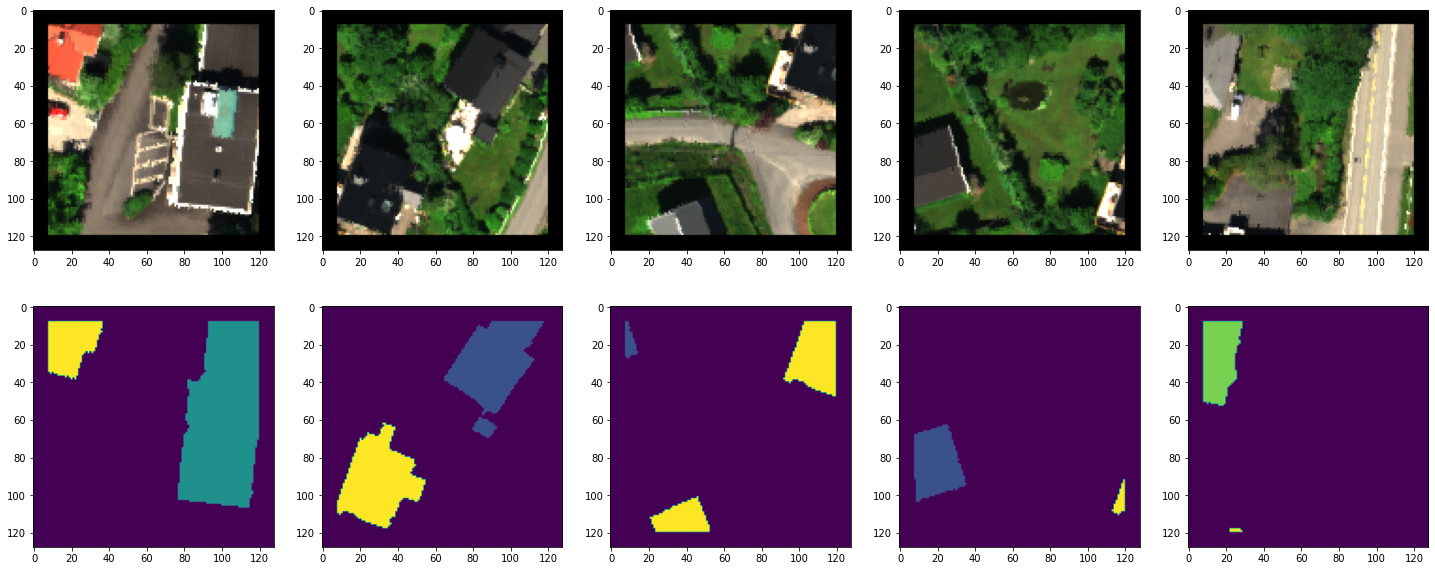

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (25,10))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
                              X_train[indx[i]][:,:,46],
                              X_train[indx[i]][:,:,21]))/2500)
    #ax[0,i].imshow(X_train[indx[i]][:,:,0:3])
    #ax[1,i].imshow(X_70_train[indx[i]][:,:,0:3])
    #ax[1,i].imshow(np.dstack((X_70_train[indx[i]][:,:,137],
    #                          X_70_train[indx[i]][:,:,194],
    #                          X_70_train[indx[i]][:,:,207])))
    ax[1,i].imshow(y_train[indx[i]].argmax(axis=2))
plt.show()

## Make U net

In [31]:
u = vanilla_unet()

img1 = Input(shape=(128,128,399))

model = u.get_unet(img1, None, n_classes=11, last_activation='softmax')

model.compile(optimizer='adam',
                         loss='categorical_crossentropy')

## Train model

In [32]:
h = model.fit(X_train,
              y_train, 
              validation_data=(X_val,y_val), 
              batch_size=16,
              epochs=150)

Epoch 1/150
10/10 [==============================] - 5s 285ms/step - loss: 2.3819 - val_loss: 5719.6641
Epoch 2/150
10/10 [==============================] - 2s 204ms/step - loss: 1.9672 - val_loss: 47061.8516
Epoch 3/150
10/10 [==============================] - 2s 206ms/step - loss: 1.7639 - val_loss: 24929.0742
Epoch 4/150
10/10 [==============================] - 2s 203ms/step - loss: 1.6196 - val_loss: 54.8756
Epoch 5/150
10/10 [==============================] - 2s 206ms/step - loss: 1.5057 - val_loss: 2.2204
Epoch 6/150
10/10 [==============================] - 2s 205ms/step - loss: 1.3971 - val_loss: 2.6467
Epoch 7/150
10/10 [==============================] - 2s 205ms/step - loss: 1.3001 - val_loss: 38.2561
Epoch 8/150
10/10 [==============================] - 2s 206ms/step - loss: 1.2085 - val_loss: 54.6218
Epoch 9/150
10/10 [==============================] - 2s 207ms/step - loss: 1.1204 - val_loss: 14.5263
Epoch 10/150
10/10 [==============================] - 2s 206ms/step - loss: 

Text(0, 0.5, 'loss')

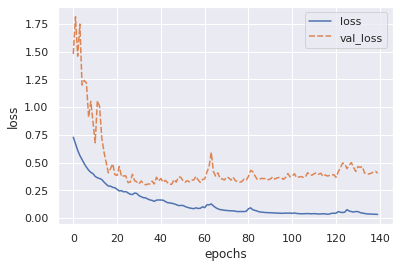

In [68]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][10:]) for key in ['loss', 'val_loss']})
plt.xlabel("epochs"); plt.ylabel("loss")

## Validate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


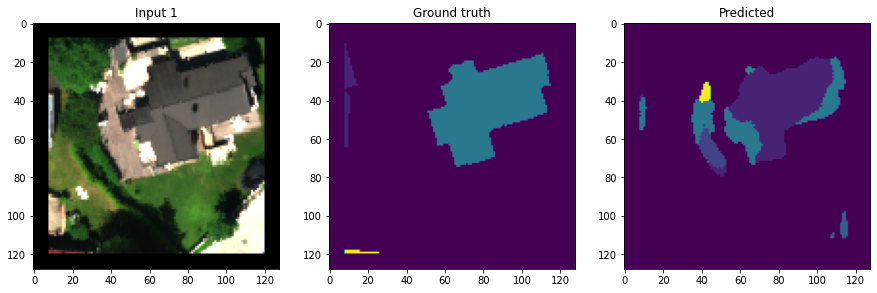

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


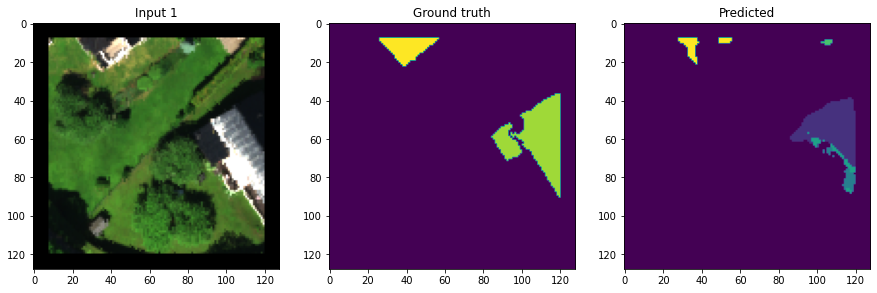

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


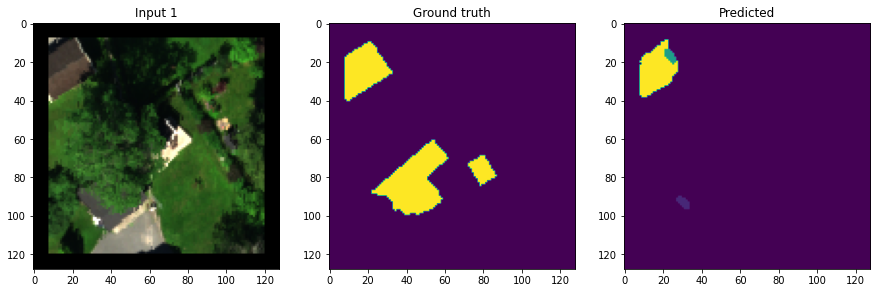

In [33]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
                        X_val[x:x+1][0][:,:,46],
                        X_val[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_val[x:x+1][0].argmax(axis=2))
  ax3.set_title("Ground truth")
  pred = model.predict([X_val[x:x+1]])[0].argmax(axis=2)
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

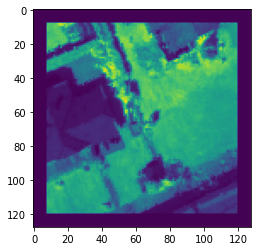

In [26]:
plt.imshow(X_test[3,:,:,150])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


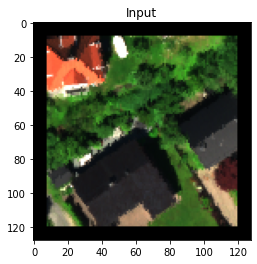

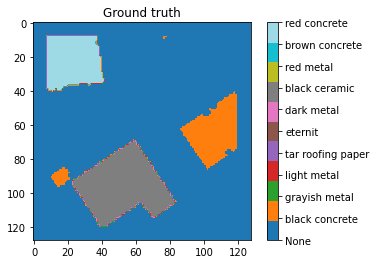

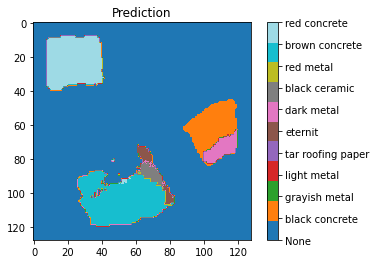

In [38]:
n = 36

plt.imshow(np.dstack([X_test[n,:,:,76], X_test[n,:,:,46], X_test[n,:,:,21]])/2500)
plt.title("Input")
plt.show()

ticks = ["None"]
ticks.extend(['black concrete',
 'grayish metal',
 'light metal',
 'tar roofing paper',
 'eternit',
 'dark metal',
 'black ceramic',
 'red metal',
 'brown concrete',
 'red concrete'])

colors=mcp.gen_color(cmap="tab20",n=11)
colormap = ListedColormap(colors)

plt.imshow(y_test[n:n+1,:,:].argmax(axis=3)[0], cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10])
cbar.ax.set_yticklabels(ticks)
plt.title("Ground truth")
plt.show()


pred = model.predict(X_test[n:n+1]).argmax(axis=3)[0]
plt.imshow(pred, cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10])
cbar.ax.set_yticklabels(ticks)
plt.title("Prediction")
plt.show()


## Metricks

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [73]:
pred_tot = model.predict(X_test)

In [74]:
pred_tot.argmax(axis=3).flatten()

(50, 128, 128, 11)

[Text(0, 0, 'None'),
 Text(0, 0, 'black ceramic'),
 Text(0, 0, 'black concrete'),
 Text(0, 0, 'brown concrete'),
 Text(0, 0, 'dark metal'),
 Text(0, 0, 'eternit'),
 Text(0, 0, 'grayish metal'),
 Text(0, 0, 'light metal'),
 Text(0, 0, 'red concrete'),
 Text(0, 0, 'red metal'),
 Text(0, 0, 'tar roofing paper')]

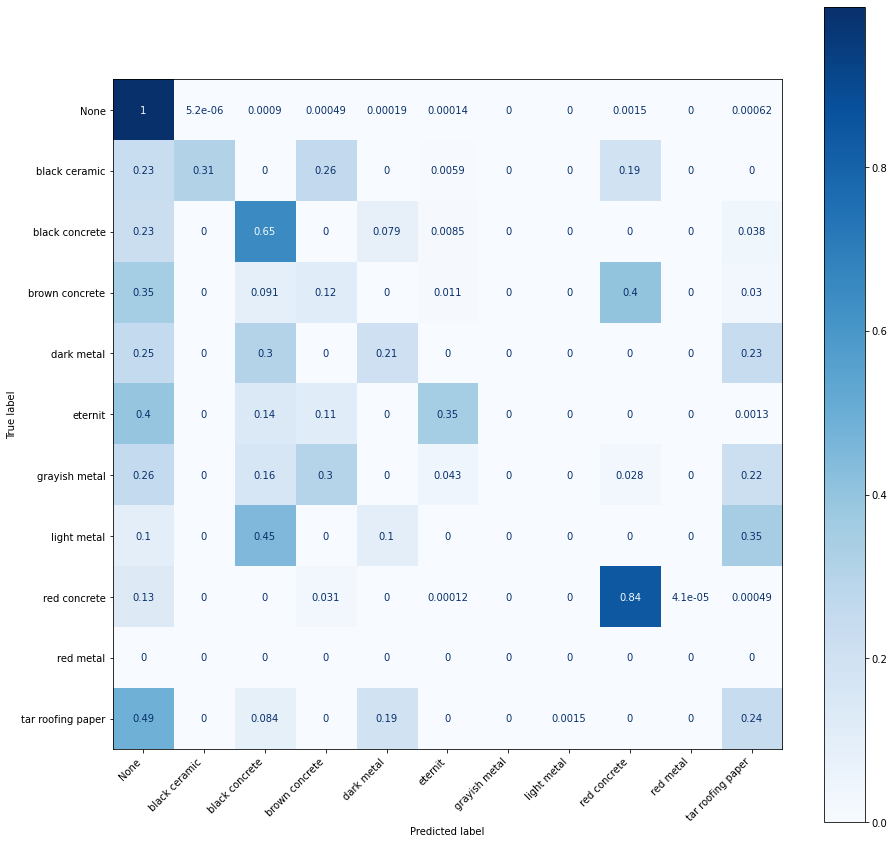

In [134]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))

ticks = np.array(ticks)
true = ticks[y_test.argmax(axis=3).flatten()]
pre = ticks[pred_tot.argmax(axis=3).flatten()]

true_ = true[true != "None"]
pre_ = pre[pre != "Noen"]


disp = ConfusionMatrixDisplay.from_predictions(true, pre,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")

In [117]:
np.unique(true)

array(['None', 'black ceramic', 'black concrete', 'brown concrete',
       'dark metal', 'eternit', 'grayish metal', 'light metal',
       'red concrete', 'tar roofing paper'], dtype='<U17')

## Shallow learning

In [7]:
from sklearn.linear_model import LogisticRegression

In [11]:
lr = LogisticRegression(verbose=1, n_jobs=-1)

In [13]:
lr.fit(X_train.reshape(150*128*128, 399)[:100000],
       y_train.reshape(150*128*128, 11).argmax(axis=1)[:100000])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.5s finished


LogisticRegression(n_jobs=-1, verbose=1)

In [14]:
pred = lr.predict(X_test.reshape(50*128*128, 399)[:10000])

In [16]:
y_test.reshape(50*128*128, 11).argmax(axis=1)[:10000]

array([0, 0, 0, ..., 0, 0, 0])

[Text(0, 0, 'None'),
 Text(0, 0, 'black ceramic'),
 Text(0, 0, 'black concrete'),
 Text(0, 0, 'brown concrete'),
 Text(0, 0, 'dark metal'),
 Text(0, 0, 'eternit'),
 Text(0, 0, 'grayish metal'),
 Text(0, 0, 'light metal'),
 Text(0, 0, 'red concrete'),
 Text(0, 0, 'red metal'),
 Text(0, 0, 'tar roofing paper')]

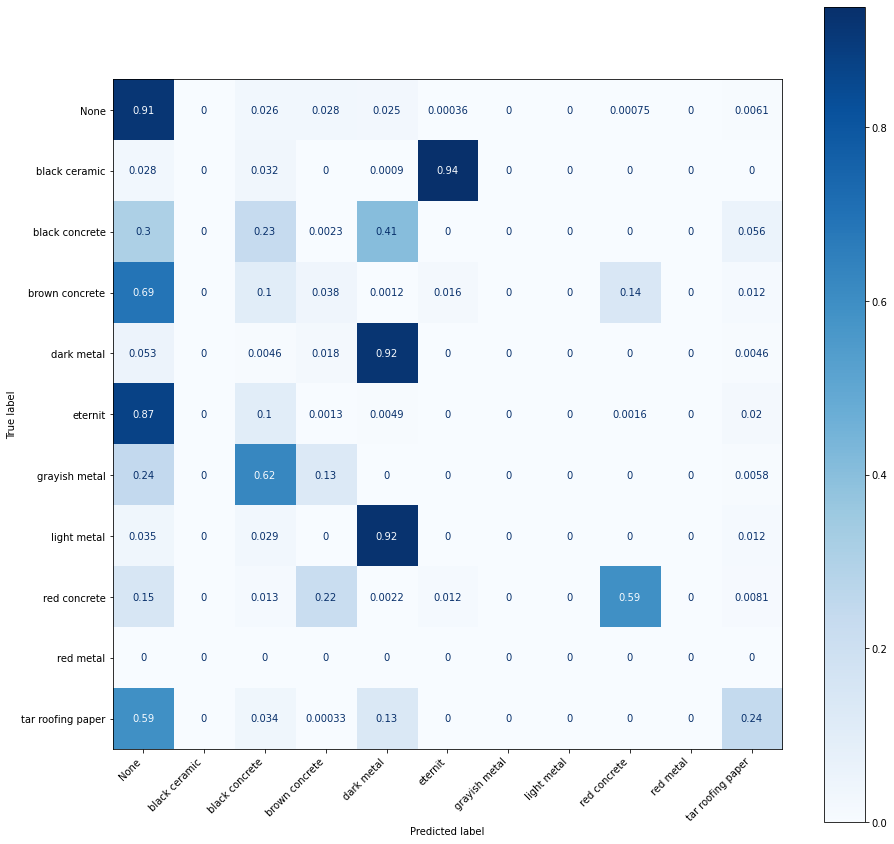

In [29]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))
ticks = np.array(ticks)


pred = ticks[lr.predict(X_test.reshape(50*128*128, 399)[:1000000])]
true = ticks[y_test.reshape(50*128*128, 11).argmax(axis=1)[:1000000]]


disp = ConfusionMatrixDisplay.from_predictions(true, pred,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")